In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import cifar10
from keras.optimizers import Adam
from keras import initializers
from keras.models import load_model

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
ls '/content/drive/My Drive/Colab Notebooks'

 gan_discriminator_epoch_20.h5
 gan_generated_image_epoch_20.png
 gan_generator_epoch_20.h5
 gan_loss_20.png
'Generative Adversarial network.ipynb'
'Keras CIFAR100 with regularizer.ipynb'
'Keras CIFAR10 With Regularizer.ipynb'
'Learn Python.ipynb'
 Pandas_NumPy_Matplotlib_practiceSheet.ipynb
 Untitled
 Untitled2.ipynb


In [0]:
# Let Keras know that we are using tensorflow as our backend engine
os.environ["KERAS_BACKEND"] = "tensorflow"

# To make sure that we can reproduce the experiment and get the same results
np.random.seed(10)

# The dimension of our random noise vector.
random_dim = 100

In [0]:
def load_cifar10():
    # load the data
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5

    x_train = x_train.reshape(50000, 3072)
    return (x_train, y_train, x_test, y_test)

In [0]:
# You will use the Adam optimizer
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [0]:
def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(3072, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

In [0]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=3072, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [0]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [0]:
d_losses = []
g_losses = []

In [0]:
# Create a wall of generated CIFAR10 images
def plot_generated_images(epoch, generator, examples=100, dim=(50, 50), figsize=(100, 100)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 32, 32, 3)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('/content/drive/My Drive/Colab Notebooks/gan_generated_image_epoch_%d.png' % epoch)

In [0]:
def plot_graph(d_losses,g_losses,epoch):
  plt.figure(figsize=(10,8))
  plt.plot(d_losses,label='D loss')
  plt.plot(g_losses, label='G loss')
  plt.title('Loss Graph Generator loss vs Discriminator loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig('/content/drive/My Drive/Colab Notebooks/gan_loss_%d.png' % epoch)

In [0]:
def saveModels(generator, discriminator, epoch):
    generator.save('/content/drive/My Drive/Colab Notebooks/gan_generator_epoch_%d.h5' % epoch)
    discriminator.save('/content/drive/My Drive/Colab Notebooks/gan_discriminator_epoch_%d.h5' % epoch)

In [0]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_cifar10()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in np.arange(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(np.arange(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake CIFAR images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, y_gen)
            
            d_losses.append(dloss)
            g_losses.append(gloss)

        if e == 1 or e % 50 == 0:
            plot_generated_images(e, generator)
            plot_graph(d_losses, g_losses,e)
            saveModels(generator,discriminator,e)

170500096/170498071 [==============================] - 17s 0us/step
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------
Instructions for updating:
Use tf.cast instead.


100%|██████████| 391/391 [02:14<00:00,  2.96it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1

--------------- Epoch 2 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 3 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 4 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 5 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 6 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 7 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 8 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 9 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 10 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 11 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 12 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 13 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 14 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 15 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 16 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 17 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 18 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 19 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 20 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 21 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 22 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 23 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 24 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 25 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 26 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 27 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 28 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 29 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 30 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 31 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 32 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 33 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 34 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 35 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 36 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 37 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 38 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 39 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 40 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 41 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 42 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 43 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 44 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 45 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 46 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 47 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 48 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 49 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 50 ---------------


100%|██████████| 391/391 [02:07<00:00,  3.02it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1

--------------- Epoch 51 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 52 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 53 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 54 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 55 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 56 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 57 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 58 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 59 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 60 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 61 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 62 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 63 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 64 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 65 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 66 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 67 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 68 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 69 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 70 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 71 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 72 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 73 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 74 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 75 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 76 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 77 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 78 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 79 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 80 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 81 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 82 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 83 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 84 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 85 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 86 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 87 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 88 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 89 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 90 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 91 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 92 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 93 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 94 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 95 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 96 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 97 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 98 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 99 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 100 ---------------


100%|██████████| 391/391 [02:06<00:00,  3.08it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1

--------------- Epoch 101 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 102 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 103 ---------------


  0%|          | 0/391 [00:00<?, ?it/s]

--------------- Epoch 104 ---------------


 26%|██▌       | 101/391 [00:32<01:33,  3.11it/s]

KeyboardInterrupt: ignored

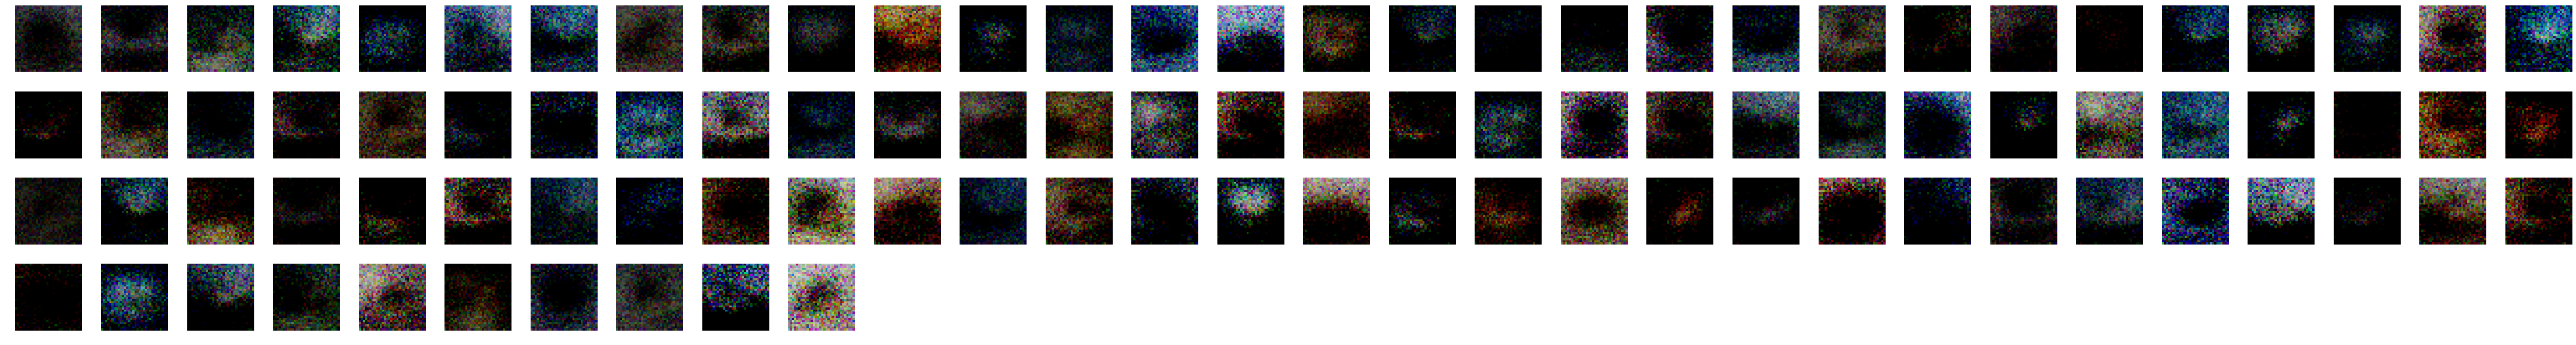

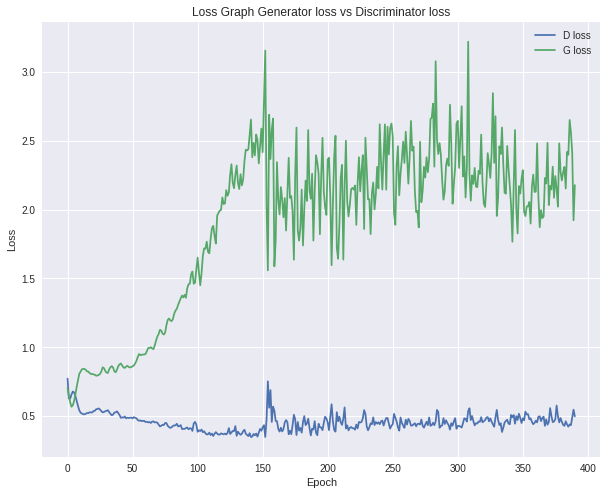

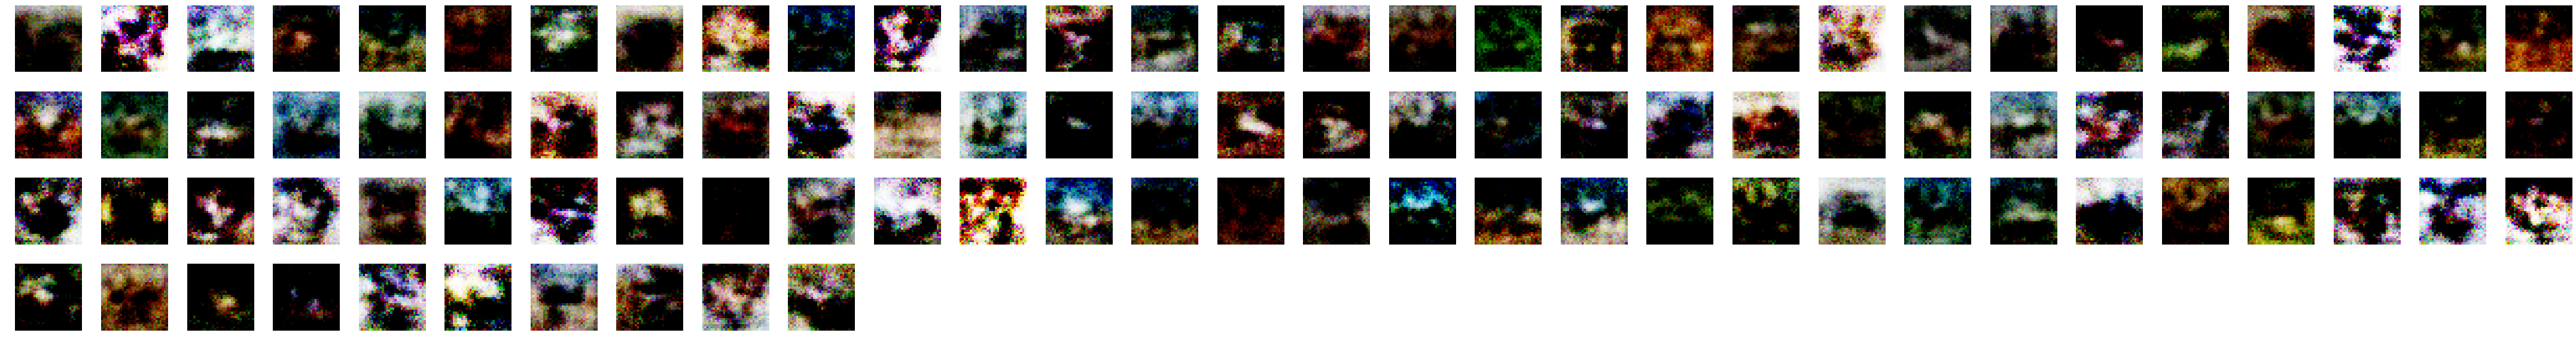

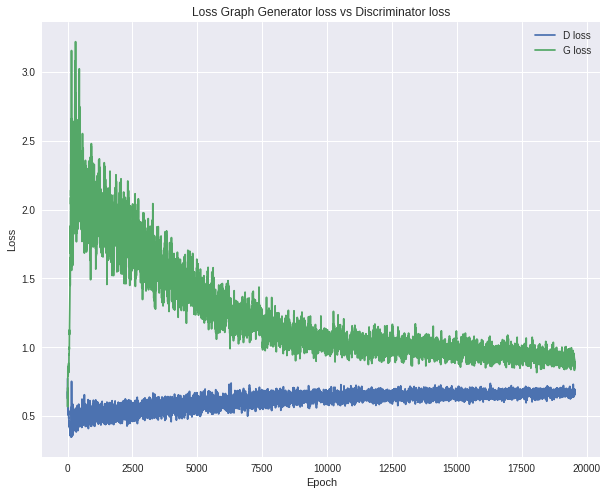

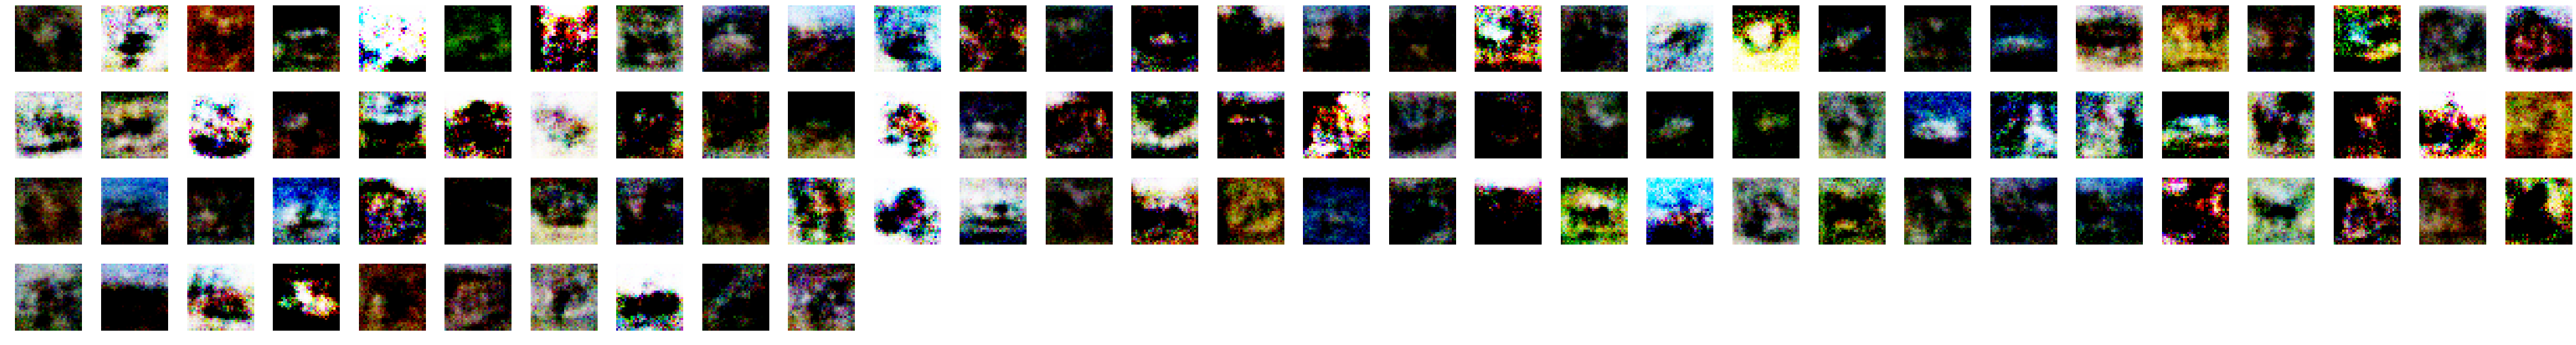

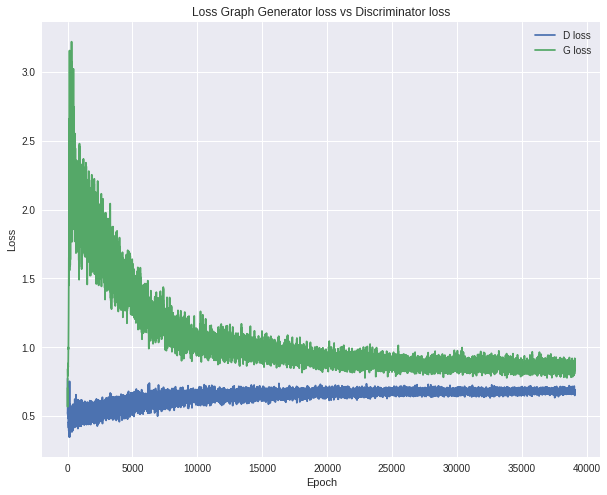

In [0]:
## Train the model 

if __name__ == '__main__':
    train(200, 128)

In [0]:
generator = load_model('/content/drive/My Drive/Colab Notebooks/gan_generator_epoch_100.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

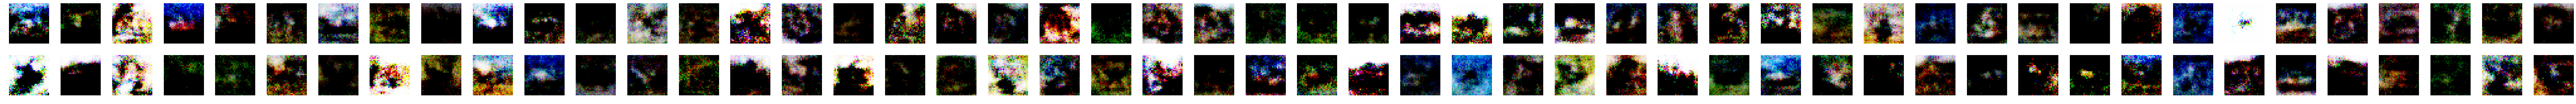

In [0]:
plot_generated_images(20,generator)